# Exploratory Data Analysis for GAN/cGAN Performance Optimization

This notebook performs comprehensive EDA on the Adult Census dataset with a specific focus on understanding data characteristics that impact GAN and cGAN training performance.

## Key Areas of Analysis:
1. **Distribution Analysis** - Non-Gaussian/multimodal distributions need mode-specific normalization
2. **Zero-Inflated Features** - Require special masking in generator
3. **Class Imbalance** - Causes mode collapse without training-by-sampling
4. **Outliers** - Lead to vanishing gradients with min-max normalization
5. **Categorical Imbalance** - Rare categories are poorly learned
6. **Feature Correlations** - Must be preserved in synthetic data

## 1. Setup and Data Loading

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.io import arff
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

In [2]:
# Load the Adult dataset
data, meta = arff.loadarff('adult.arff')
df = pd.DataFrame(data)

# Decode byte strings to regular strings
for col in df.columns:
    if df[col].dtype == object:
        df[col] = df[col].str.decode('utf-8')

print(f"Dataset Shape: {df.shape}")
print(f"\nFeatures: {list(df.columns)}")

Dataset Shape: (32561, 15)

Features: ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income']


In [3]:
# Define feature types
continuous_features = ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
categorical_features = ['workclass', 'education', 'marital-status', 'occupation', 
                        'relationship', 'race', 'sex', 'native-country']
target = 'income'  # Fixed: column is 'income' not 'class'

print(f"Continuous features ({len(continuous_features)}): {continuous_features}")
print(f"\nCategorical features ({len(categorical_features)}): {categorical_features}")
print(f"\nTarget: {target}")

Continuous features (6): ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

Categorical features (8): ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']

Target: income


In [4]:
# Basic data info
print("Data Types:")
print(df.dtypes)
print("\n" + "="*50)
print("\nSummary Statistics for Continuous Features:")
df[continuous_features].describe()

Data Types:
age               float64
workclass          object
fnlwgt            float64
education          object
education-num     float64
marital-status     object
occupation         object
relationship       object
race               object
sex                object
capital-gain      float64
capital-loss      float64
hours-per-week    float64
native-country     object
income             object
dtype: object


Summary Statistics for Continuous Features:


,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


## 2. Missing Value Analysis

**GAN Impact**: Missing values must be imputed before training. The imputation strategy affects what the GAN learns as "real" data patterns.

Missing Values Summary:
       Feature  Missing Count  Missing %
    occupation           1843   5.660146
     workclass           1836   5.638647
native-country            583   1.790486


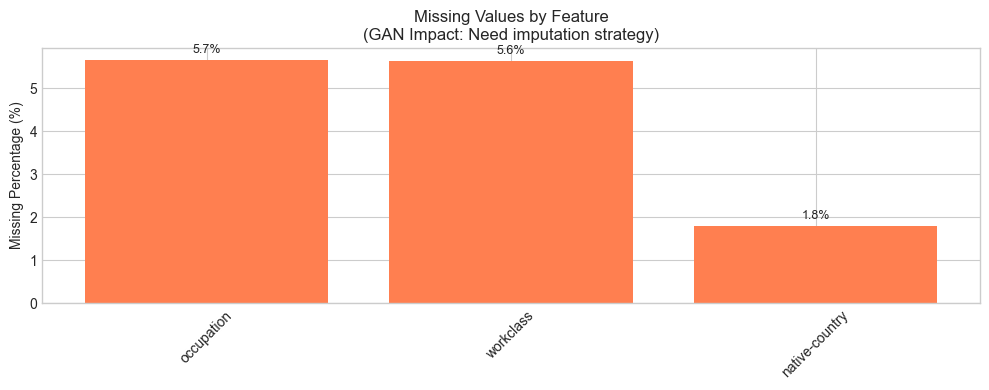

In [5]:
# Count missing values (represented as '?' in this dataset)
missing_counts = {}
for col in df.columns:
    if df[col].dtype == object:
        missing_count = (df[col] == '?').sum()
        if missing_count > 0:
            missing_counts[col] = missing_count

if missing_counts:
    missing_df = pd.DataFrame({
        'Feature': list(missing_counts.keys()),
        'Missing Count': list(missing_counts.values()),
        'Missing %': [count/len(df)*100 for count in missing_counts.values()]
    }).sort_values('Missing Count', ascending=False)
    
    print("Missing Values Summary:")
    print(missing_df.to_string(index=False))
    
    # Visualize
    fig, ax = plt.subplots(figsize=(10, 4))
    bars = ax.bar(missing_df['Feature'], missing_df['Missing %'], color='coral')
    ax.set_ylabel('Missing Percentage (%)')
    ax.set_title('Missing Values by Feature\n(GAN Impact: Need imputation strategy)')
    ax.tick_params(axis='x', rotation=45)
    for bar, pct in zip(bars, missing_df['Missing %']):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, 
                f'{pct:.1f}%', ha='center', va='bottom', fontsize=9)
    plt.tight_layout()
    plt.show()
else:
    print("No missing values found!")

## 3. Target Variable Analysis (Class Imbalance)

**GAN Impact**: Severe class imbalance causes mode collapse where the generator only learns the majority class. cGAN's training-by-sampling technique mitigates this by uniformly sampling from all classes during training.

Target Variable Distribution:
  <=50K: 24,720 samples (75.9%)
  >50K: 7,841 samples (24.1%)

Imbalance Ratio: 3.15:1


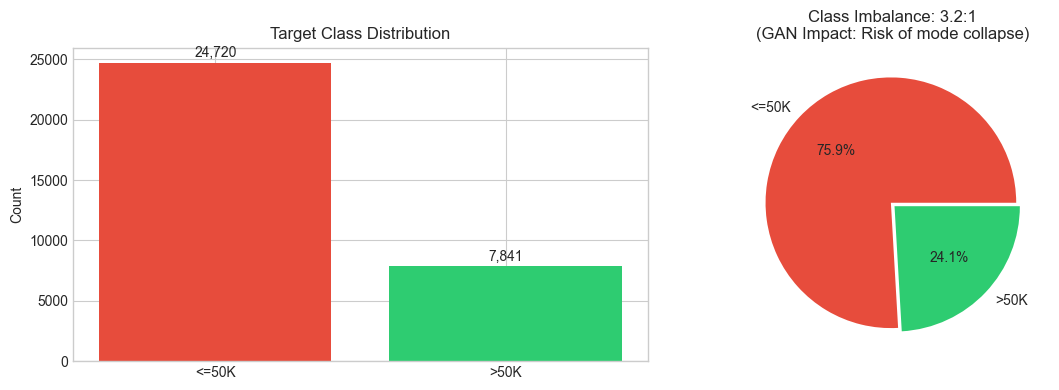

In [6]:
# Target distribution
target_counts = df[target].value_counts()
target_pcts = df[target].value_counts(normalize=True) * 100

print("Target Variable Distribution:")
for label in target_counts.index:
    print(f"  {label}: {target_counts[label]:,} samples ({target_pcts[label]:.1f}%)")

# Calculate imbalance ratio
imbalance_ratio = target_counts.max() / target_counts.min()
print(f"\nImbalance Ratio: {imbalance_ratio:.2f}:1")

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Bar chart
colors = ['#2ecc71' if '>' in label else '#e74c3c' for label in target_counts.index]
axes[0].bar(target_counts.index, target_counts.values, color=colors)
axes[0].set_ylabel('Count')
axes[0].set_title('Target Class Distribution')
for i, (label, count) in enumerate(target_counts.items()):
    axes[0].text(i, count + 500, f'{count:,}', ha='center')

# Pie chart
axes[1].pie(target_counts.values, labels=target_counts.index, autopct='%1.1f%%', 
            colors=colors, explode=[0.02, 0.02])
axes[1].set_title(f'Class Imbalance: {imbalance_ratio:.1f}:1\n(GAN Impact: Risk of mode collapse)')

plt.tight_layout()
plt.show()

## 4. Continuous Feature Distributions

**GAN Impact**: Non-Gaussian and multimodal distributions are challenging for GANs. Mode-specific normalization (as in CTGAN) helps by:
1. Fitting a Gaussian Mixture Model to detect modes
2. Normalizing within each mode separately
3. Providing mode indicators to the generator

In [7]:
def analyze_distribution(data, feature_name):
    """Analyze a continuous feature's distribution for GAN training."""
    values = data[feature_name].dropna().values
    
    # Basic statistics
    skewness = stats.skew(values)
    kurtosis = stats.kurtosis(values)
    
    # Test for normality
    if len(values) > 5000:
        # Use sample for large datasets
        sample = np.random.choice(values, 5000, replace=False)
        _, p_value = stats.normaltest(sample)
    else:
        _, p_value = stats.normaltest(values)
    
    # Detect number of modes using GMM
    best_n_modes = 1
    best_bic = np.inf
    values_reshaped = values.reshape(-1, 1)
    
    for n in range(1, 6):
        try:
            gmm = GaussianMixture(n_components=n, random_state=42, max_iter=100)
            gmm.fit(values_reshaped)
            bic = gmm.bic(values_reshaped)
            if bic < best_bic:
                best_bic = bic
                best_n_modes = n
        except:
            break
    
    return {
        'feature': feature_name,
        'skewness': skewness,
        'kurtosis': kurtosis,
        'is_normal': p_value > 0.05,
        'p_value': p_value,
        'n_modes': best_n_modes
    }

# Analyze all continuous features
dist_analysis = [analyze_distribution(df, feat) for feat in continuous_features]
dist_df = pd.DataFrame(dist_analysis)

print("Distribution Analysis Summary:")
print("="*80)
for _, row in dist_df.iterrows():
    status = "Normal" if row['is_normal'] else "Non-Gaussian"
    mode_warning = " [MULTIMODAL]" if row['n_modes'] > 1 else ""
    skew_warning = " [HIGH SKEW]" if abs(row['skewness']) > 1 else ""
    print(f"{row['feature']:20s} | Skew: {row['skewness']:7.2f} | Modes: {row['n_modes']} | {status}{mode_warning}{skew_warning}")

Distribution Analysis Summary:
age                  | Skew:    0.56 | Modes: 5 | Non-Gaussian [MULTIMODAL]
fnlwgt               | Skew:    1.45 | Modes: 5 | Non-Gaussian [MULTIMODAL] [HIGH SKEW]
education-num        | Skew:   -0.31 | Modes: 4 | Non-Gaussian [MULTIMODAL]
capital-gain         | Skew:   11.95 | Modes: 5 | Non-Gaussian [MULTIMODAL] [HIGH SKEW]
capital-loss         | Skew:    4.59 | Modes: 4 | Non-Gaussian [MULTIMODAL] [HIGH SKEW]
hours-per-week       | Skew:    0.23 | Modes: 5 | Non-Gaussian [MULTIMODAL]


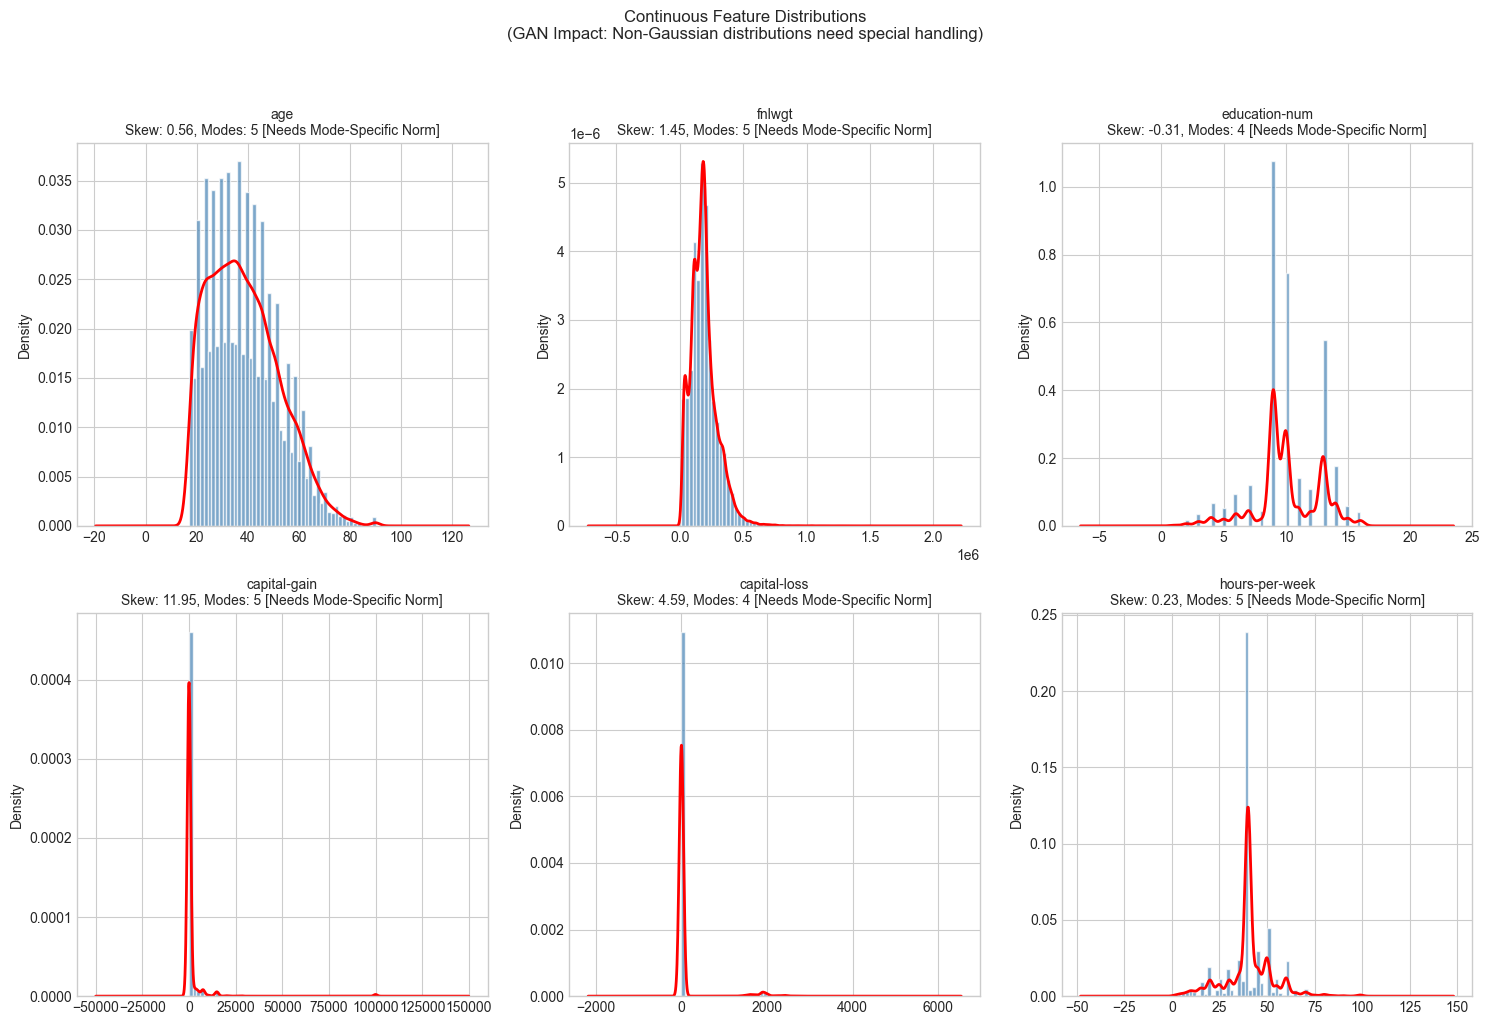

In [8]:
# Visualize distributions
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for idx, feature in enumerate(continuous_features):
    ax = axes[idx]
    values = df[feature].dropna()
    
    # Histogram with KDE
    ax.hist(values, bins=50, density=True, alpha=0.7, color='steelblue', edgecolor='white')
    
    # Add KDE
    try:
        values.plot.kde(ax=ax, color='red', linewidth=2, label='KDE')
    except:
        pass
    
    # Get analysis results
    analysis = dist_df[dist_df['feature'] == feature].iloc[0]
    
    title = f"{feature}\nSkew: {analysis['skewness']:.2f}, Modes: {analysis['n_modes']}"
    if analysis['n_modes'] > 1:
        title += " [Needs Mode-Specific Norm]"
    ax.set_title(title, fontsize=10)
    ax.set_xlabel('')

plt.suptitle('Continuous Feature Distributions\n(GAN Impact: Non-Gaussian distributions need special handling)', 
             fontsize=12, y=1.02)
plt.tight_layout()
plt.show()

## 5. Zero-Inflated Feature Analysis

**GAN Impact**: Features with many zeros (like capital-gain/loss) require special handling:
1. **Separate zero-mask**: Generator learns when to output zero vs non-zero
2. **Log-transform non-zeros**: Reduces skewness of non-zero values
3. **Two-part model**: Probability of zero + distribution of non-zeros

Zero-Inflated Feature Analysis:

capital-gain:
  Zeros: 29,849 (91.7%)
  Non-zeros: 2,712 (8.3%)
  Non-zero mean: 12938.54
  Non-zero median: 7298.00
  Non-zero max: 99999.00

capital-loss:
  Zeros: 31,042 (95.3%)
  Non-zeros: 1,519 (4.7%)
  Non-zero mean: 1871.43
  Non-zero median: 1887.00
  Non-zero max: 4356.00


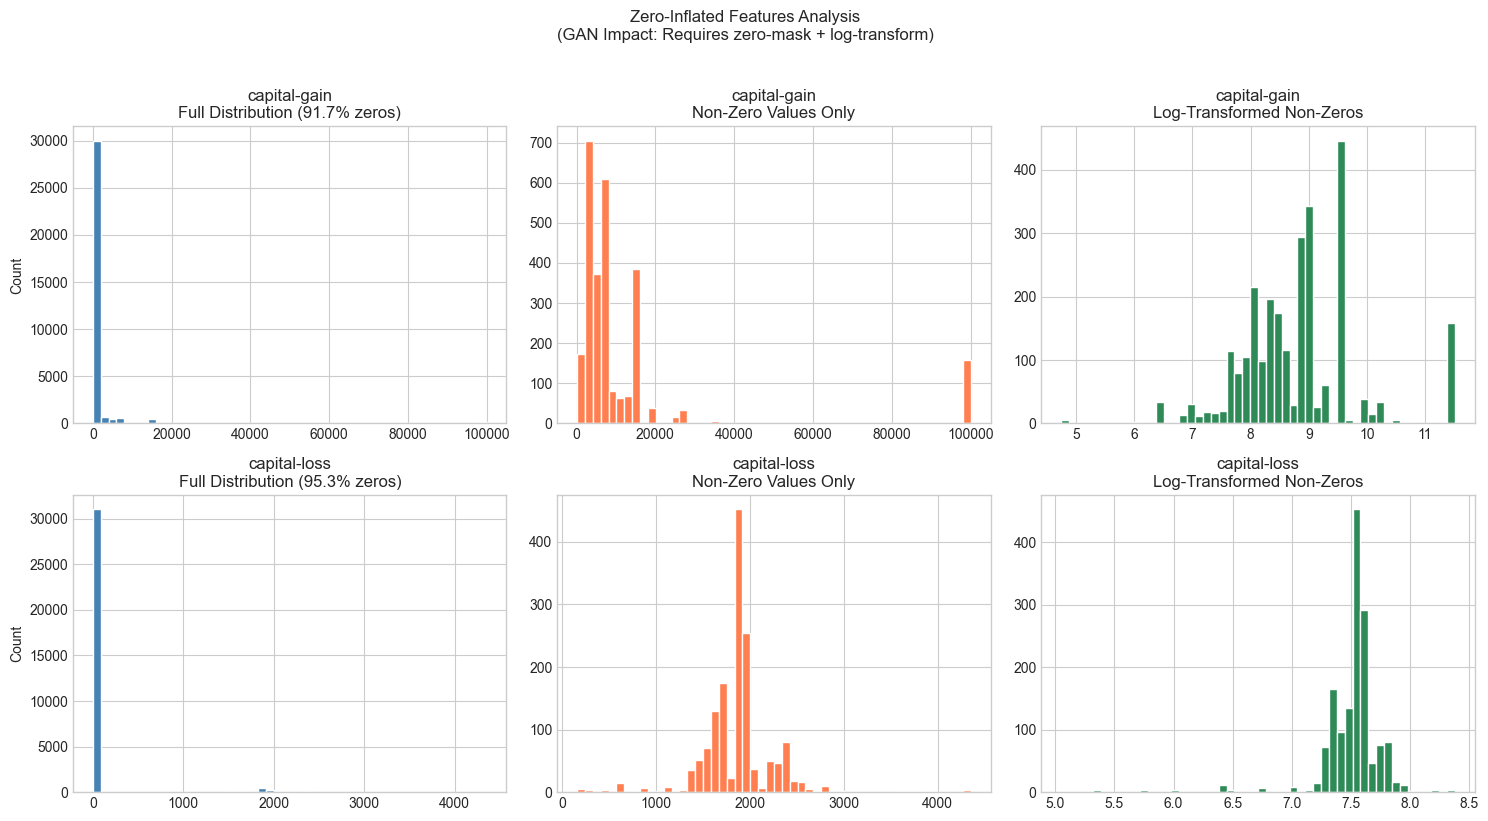

In [9]:
# Analyze zero-inflation
zero_inflated_features = ['capital-gain', 'capital-loss']

print("Zero-Inflated Feature Analysis:")
print("="*60)

fig, axes = plt.subplots(2, 3, figsize=(15, 8))

for idx, feature in enumerate(zero_inflated_features):
    values = df[feature]
    zero_count = (values == 0).sum()
    zero_pct = zero_count / len(values) * 100
    nonzero_values = values[values > 0]
    
    print(f"\n{feature}:")
    print(f"  Zeros: {zero_count:,} ({zero_pct:.1f}%)")
    print(f"  Non-zeros: {len(nonzero_values):,} ({100-zero_pct:.1f}%)")
    print(f"  Non-zero mean: {nonzero_values.mean():.2f}")
    print(f"  Non-zero median: {nonzero_values.median():.2f}")
    print(f"  Non-zero max: {nonzero_values.max():.2f}")
    
    # Plot 1: Full distribution (with zeros)
    ax1 = axes[idx, 0]
    ax1.hist(values, bins=50, color='steelblue', edgecolor='white')
    ax1.set_title(f'{feature}\nFull Distribution ({zero_pct:.1f}% zeros)')
    ax1.set_ylabel('Count')
    
    # Plot 2: Non-zero values only
    ax2 = axes[idx, 1]
    ax2.hist(nonzero_values, bins=50, color='coral', edgecolor='white')
    ax2.set_title(f'{feature}\nNon-Zero Values Only')
    
    # Plot 3: Log-transformed non-zeros
    ax3 = axes[idx, 2]
    log_values = np.log1p(nonzero_values)
    ax3.hist(log_values, bins=50, color='seagreen', edgecolor='white')
    ax3.set_title(f'{feature}\nLog-Transformed Non-Zeros')

plt.suptitle('Zero-Inflated Features Analysis\n(GAN Impact: Requires zero-mask + log-transform)', 
             fontsize=12, y=1.02)
plt.tight_layout()
plt.show()

In [10]:
# Compare zero-inflation by target class
print("\nZero-Inflation by Income Class:")
print("="*60)

for feature in zero_inflated_features:
    print(f"\n{feature}:")
    for label in df[target].unique():
        subset = df[df[target] == label][feature]
        zero_pct = (subset == 0).sum() / len(subset) * 100
        nonzero_mean = subset[subset > 0].mean() if (subset > 0).any() else 0
        print(f"  {label}: {zero_pct:.1f}% zeros, non-zero mean: ${nonzero_mean:,.0f}")


Zero-Inflation by Income Class:

capital-gain:
  <=50K: 95.8% zeros, non-zero mean: $3,553
  >50K: 78.6% zeros, non-zero mean: $18,731

capital-loss:
  <=50K: 97.0% zeros, non-zero mean: $1,761
  >50K: 90.1% zeros, non-zero mean: $1,978


## 6. Outlier Detection

**GAN Impact**: Outliers cause problems with min-max normalization:
- Extreme values squeeze all other values toward -1 or 0
- This leads to vanishing gradients in tanh activations
- Solutions: Robust scaling, clipping, or mode-specific normalization

In [11]:
def detect_outliers(values, method='iqr'):
    """Detect outliers using IQR method."""
    Q1 = np.percentile(values, 25)
    Q3 = np.percentile(values, 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = (values < lower_bound) | (values > upper_bound)
    return outliers, lower_bound, upper_bound

# Analyze outliers in each continuous feature
print("Outlier Analysis (IQR Method):")
print("="*70)

outlier_summary = []
for feature in continuous_features:
    values = df[feature].values
    outliers, lower, upper = detect_outliers(values)
    n_outliers = outliers.sum()
    pct_outliers = n_outliers / len(values) * 100
    
    outlier_summary.append({
        'Feature': feature,
        'Outliers': n_outliers,
        'Pct': pct_outliers,
        'Lower Bound': lower,
        'Upper Bound': upper
    })
    
    severity = "HIGH" if pct_outliers > 5 else "MODERATE" if pct_outliers > 1 else "LOW"
    print(f"{feature:20s} | Outliers: {n_outliers:6,} ({pct_outliers:5.1f}%) | Severity: {severity}")

outlier_df = pd.DataFrame(outlier_summary)

Outlier Analysis (IQR Method):
age                  | Outliers:    143 (  0.4%) | Severity: LOW
fnlwgt               | Outliers:    992 (  3.0%) | Severity: MODERATE
education-num        | Outliers:  1,198 (  3.7%) | Severity: MODERATE
capital-gain         | Outliers:  2,712 (  8.3%) | Severity: HIGH
capital-loss         | Outliers:  1,519 (  4.7%) | Severity: MODERATE
hours-per-week       | Outliers:  9,008 ( 27.7%) | Severity: HIGH


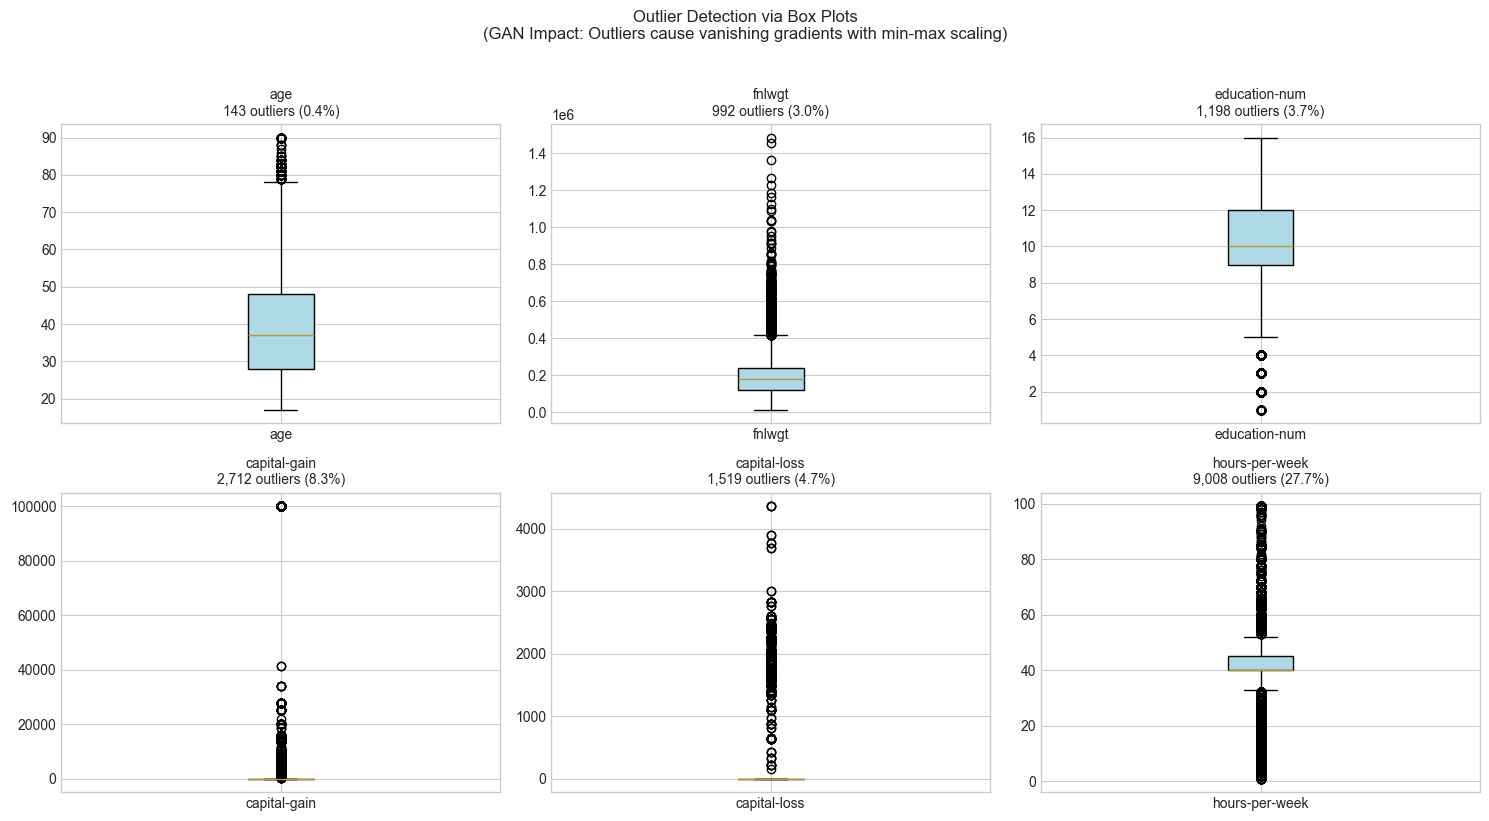

In [12]:
# Visualize with box plots
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for idx, feature in enumerate(continuous_features):
    ax = axes[idx]
    
    # Create box plot
    bp = ax.boxplot(df[feature].dropna(), patch_artist=True)
    bp['boxes'][0].set_facecolor('lightblue')
    
    # Get outlier info
    info = outlier_df[outlier_df['Feature'] == feature].iloc[0]
    
    title = f"{feature}\n{info['Outliers']:,} outliers ({info['Pct']:.1f}%)"
    ax.set_title(title, fontsize=10)
    ax.set_xticklabels([feature])

plt.suptitle('Outlier Detection via Box Plots\n(GAN Impact: Outliers cause vanishing gradients with min-max scaling)', 
             fontsize=12, y=1.02)
plt.tight_layout()
plt.show()

## 7. Categorical Feature Analysis

**GAN Impact**: 
- Highly imbalanced categories lead to mode collapse (rare categories not generated)
- One-hot encoding creates sparse vectors that are easy for discriminator to detect
- Categories with <1% frequency may not be learned at all

In [13]:
# Analyze categorical features
print("Categorical Feature Analysis:")
print("="*70)

cat_summary = []
for feature in categorical_features:
    values = df[feature]
    n_categories = values.nunique()
    value_counts = values.value_counts(normalize=True) * 100
    
    # Find rare categories (< 1%)
    rare_cats = (value_counts < 1).sum()
    min_freq = value_counts.min()
    max_freq = value_counts.max()
    
    cat_summary.append({
        'Feature': feature,
        'Categories': n_categories,
        'Rare (<1%)': rare_cats,
        'Min Freq %': min_freq,
        'Max Freq %': max_freq,
        'Imbalance': max_freq / min_freq if min_freq > 0 else np.inf
    })

cat_df = pd.DataFrame(cat_summary)
print(cat_df.to_string(index=False))

Categorical Feature Analysis:
       Feature  Categories  Rare (<1%)  Min Freq %  Max Freq %    Imbalance
     workclass           9           2    0.021498   69.703019  3242.285714
     education          16           2    0.156629   32.250238   205.901961
marital-status           7           1    0.070637   45.993673   651.130435
    occupation          15           2    0.027640   12.714597   460.000000
  relationship           6           0    3.012807   40.517797    13.448522
          race           5           2    0.832284   85.427352   102.642066
           sex           2           0   33.079451   66.920549     2.023025
native-country          42          39    0.003071   89.585701 29170.000000


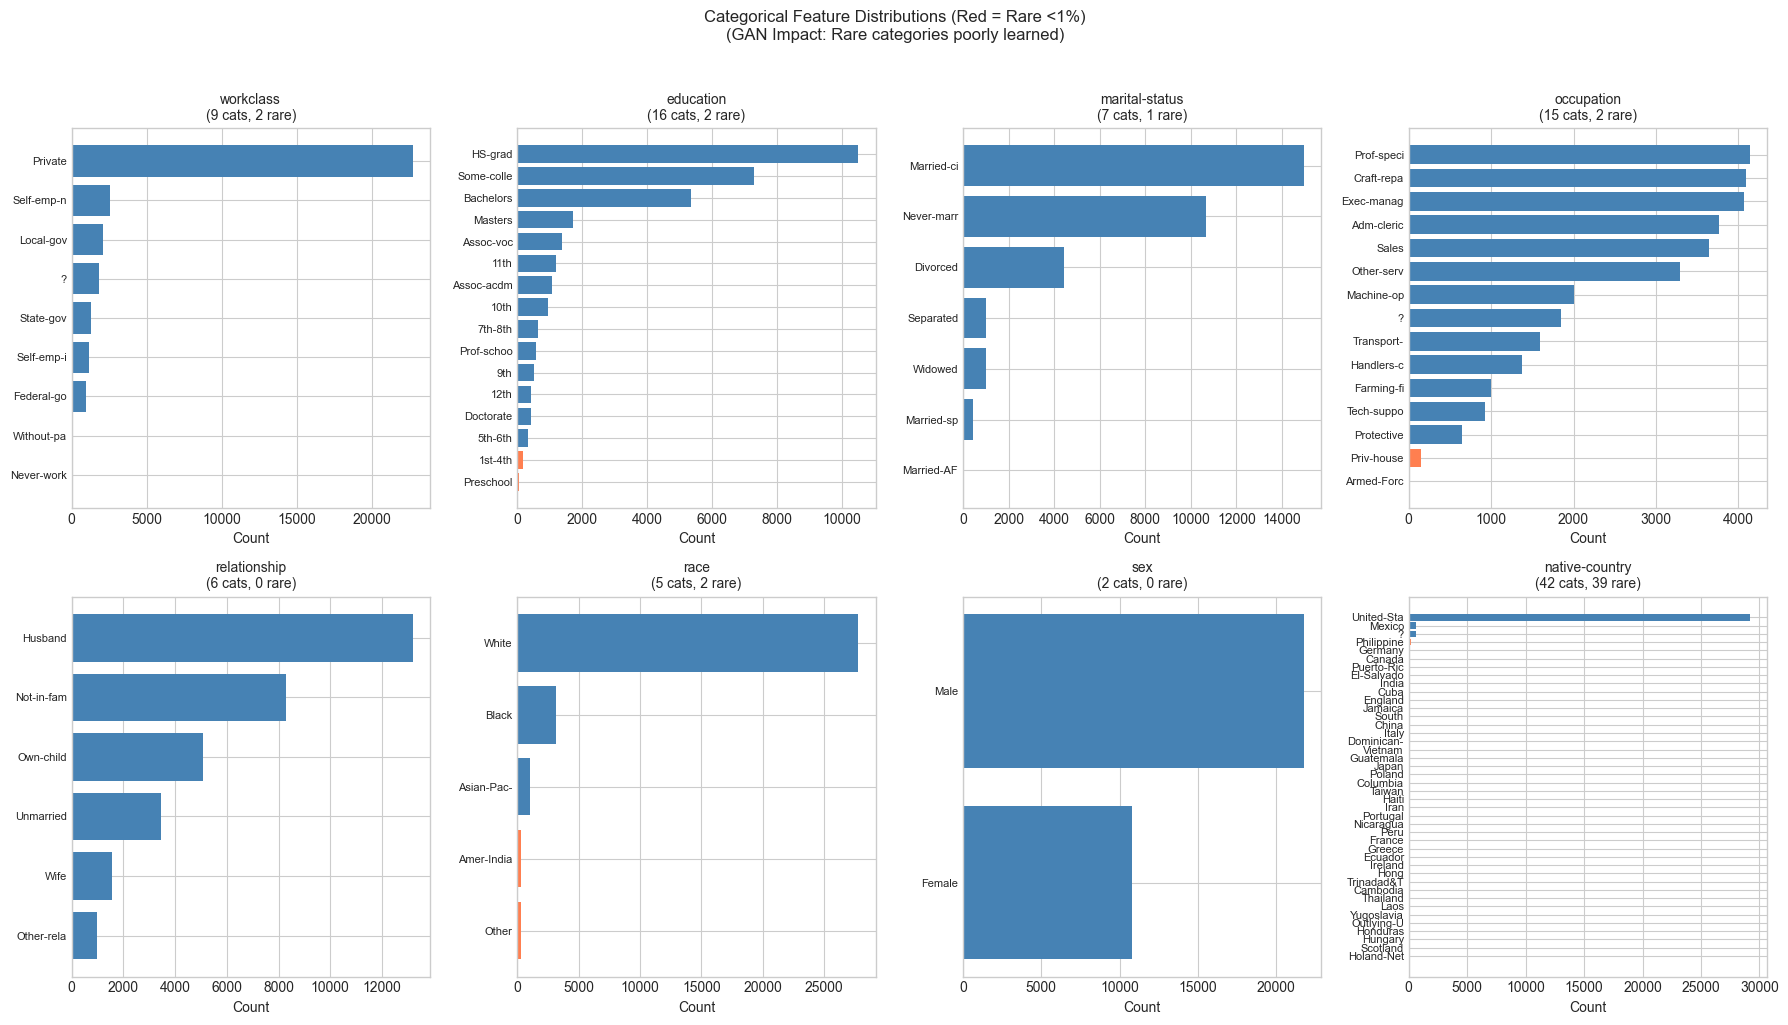

In [14]:
# Visualize category distributions
fig, axes = plt.subplots(2, 4, figsize=(18, 10))
axes = axes.flatten()

for idx, feature in enumerate(categorical_features):
    ax = axes[idx]
    value_counts = df[feature].value_counts()
    
    # Color rare categories differently
    pcts = value_counts / len(df) * 100
    colors = ['coral' if pct < 1 else 'steelblue' for pct in pcts]
    
    # Truncate labels for readability
    labels = [str(x)[:10] for x in value_counts.index]
    
    ax.barh(range(len(value_counts)), value_counts.values, color=colors)
    ax.set_yticks(range(len(value_counts)))
    ax.set_yticklabels(labels, fontsize=8)
    ax.invert_yaxis()
    
    rare_count = (pcts < 1).sum()
    ax.set_title(f"{feature}\n({len(value_counts)} cats, {rare_count} rare)", fontsize=10)
    ax.set_xlabel('Count')

plt.suptitle('Categorical Feature Distributions (Red = Rare <1%)\n(GAN Impact: Rare categories poorly learned)', 
             fontsize=12, y=1.02)
plt.tight_layout()
plt.show()

## 8. Feature Correlation Analysis

**GAN Impact**: 
- GANs must learn to preserve feature correlations in generated data
- High correlations between features create dependencies the generator must capture
- Correlation matrix comparison is a key metric for evaluating synthetic data quality

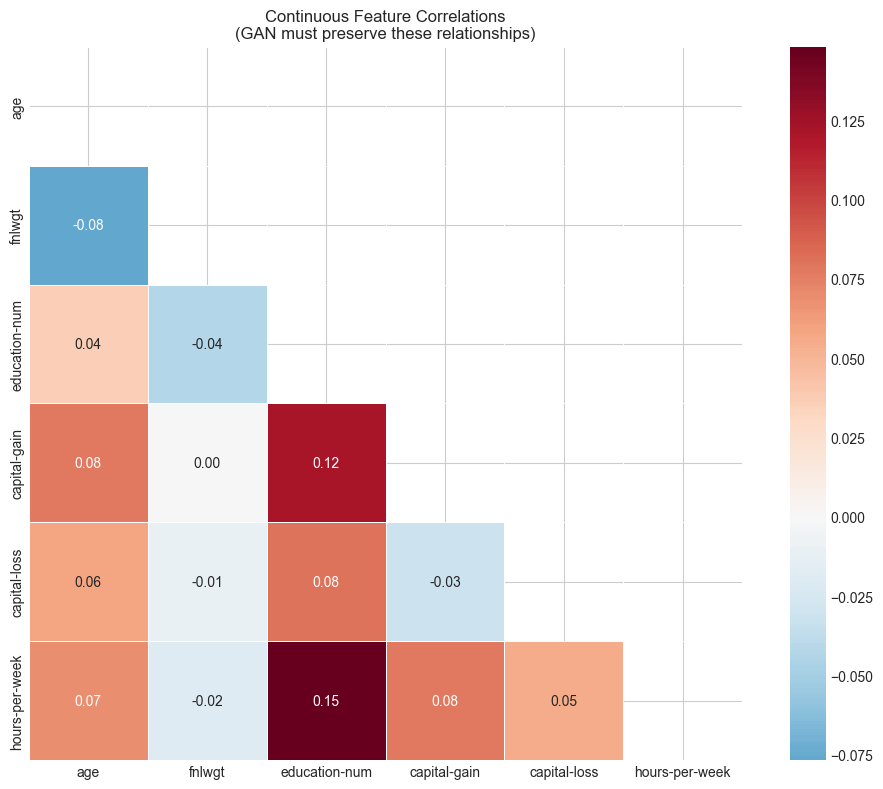


Significant Correlations (|r| > 0.3):


In [15]:
# Correlation matrix for continuous features
corr_matrix = df[continuous_features].corr()

fig, ax = plt.subplots(figsize=(10, 8))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='RdBu_r', center=0,
            fmt='.2f', square=True, linewidths=0.5, ax=ax)
ax.set_title('Continuous Feature Correlations\n(GAN must preserve these relationships)', fontsize=12)
plt.tight_layout()
plt.show()

# Find significant correlations
print("\nSignificant Correlations (|r| > 0.3):")
print("="*50)
for i in range(len(continuous_features)):
    for j in range(i+1, len(continuous_features)):
        corr = corr_matrix.iloc[i, j]
        if abs(corr) > 0.3:
            print(f"{continuous_features[i]} <-> {continuous_features[j]}: {corr:.3f}")

## 9. Feature-Target Relationships

**GAN Impact for cGAN**: The conditional generator must learn these label-feature dependencies to generate realistic samples for each class.

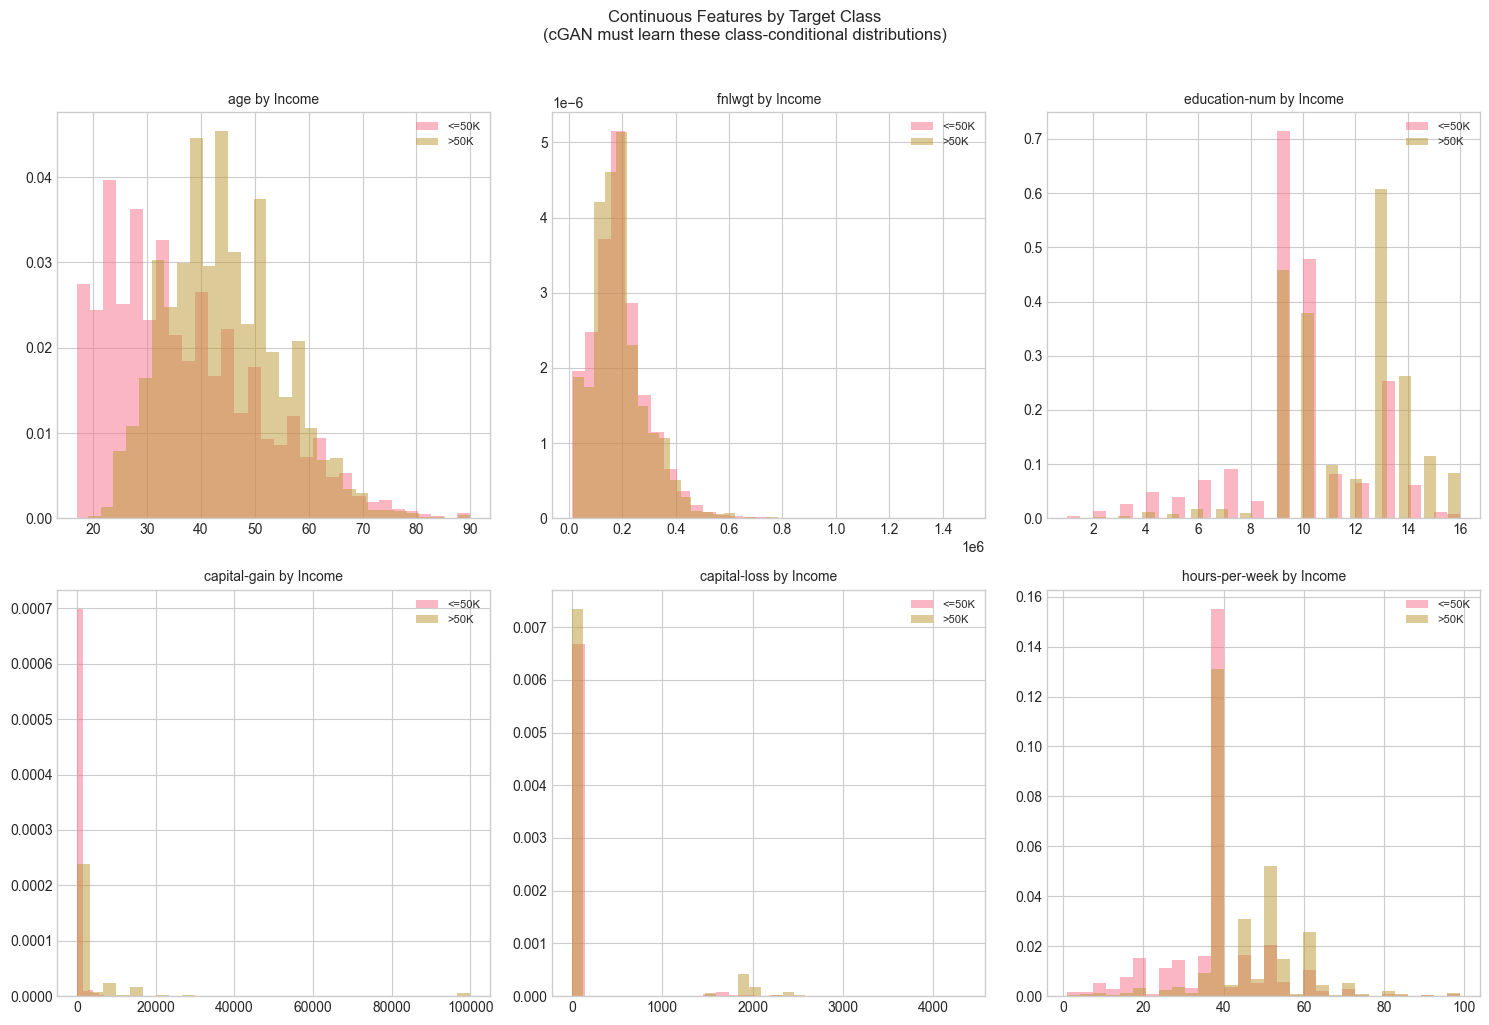

In [16]:
# Continuous features by target class
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for idx, feature in enumerate(continuous_features):
    ax = axes[idx]
    
    for label in df[target].unique():
        subset = df[df[target] == label][feature]
        ax.hist(subset, bins=30, alpha=0.5, label=label, density=True)
    
    ax.set_title(f'{feature} by Income', fontsize=10)
    ax.legend(fontsize=8)
    ax.set_xlabel('')

plt.suptitle('Continuous Features by Target Class\n(cGAN must learn these class-conditional distributions)', 
             fontsize=12, y=1.02)
plt.tight_layout()
plt.show()

In [17]:
# Statistical tests for feature-target association
print("Feature-Target Association Strength:")
print("="*60)

# For continuous features: point-biserial correlation
print("\nContinuous Features (Point-Biserial Correlation):")
le = LabelEncoder()
y_encoded = le.fit_transform(df[target])

for feature in continuous_features:
    corr, p_value = stats.pointbiserialr(y_encoded, df[feature])
    significance = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else ""
    print(f"  {feature:20s}: r = {corr:+.3f} {significance}")

# For categorical features: Cramér's V
print("\nCategorical Features (Cramér's V):")
for feature in categorical_features:
    contingency = pd.crosstab(df[feature], df[target])
    chi2 = stats.chi2_contingency(contingency)[0]
    n = contingency.sum().sum()
    min_dim = min(contingency.shape) - 1
    cramers_v = np.sqrt(chi2 / (n * min_dim)) if min_dim > 0 else 0
    strength = "Strong" if cramers_v > 0.3 else "Moderate" if cramers_v > 0.1 else "Weak"
    print(f"  {feature:20s}: V = {cramers_v:.3f} ({strength})")

Feature-Target Association Strength:

Continuous Features (Point-Biserial Correlation):
  age                 : r = +0.234 ***
  fnlwgt              : r = -0.009 
  education-num       : r = +0.335 ***
  capital-gain        : r = +0.223 ***
  capital-loss        : r = +0.151 ***
  hours-per-week      : r = +0.230 ***

Categorical Features (Cramér's V):
  workclass           : V = 0.179 (Moderate)
  education           : V = 0.369 (Strong)
  marital-status      : V = 0.447 (Strong)
  occupation          : V = 0.352 (Strong)
  relationship        : V = 0.454 (Strong)
  race                : V = 0.101 (Moderate)
  sex                 : V = 0.216 (Moderate)
  native-country      : V = 0.099 (Weak)


## 10. Sparsity Analysis (One-Hot Encoding)

**GAN Impact**: 
- One-hot encoding expands 8 categorical features to ~98 binary dimensions
- Total feature dimension: 6 continuous + 98 one-hot = 104 dimensions
- Sparse one-hot vectors make discriminator's job easier (trivial to detect fake patterns)
- Solutions: Embedding layers, Gumbel-Softmax for differentiable sampling

In [18]:
# Calculate one-hot dimensions
print("Dimensionality Expansion from One-Hot Encoding:")
print("="*60)

total_onehot_dims = 0
for feature in categorical_features:
    n_cats = df[feature].nunique()
    total_onehot_dims += n_cats
    print(f"  {feature:20s}: {n_cats:3d} dimensions")

total_dims = len(continuous_features) + total_onehot_dims
print(f"\n  {'Continuous features':20s}: {len(continuous_features):3d} dimensions")
print(f"  {'One-hot categorical':20s}: {total_onehot_dims:3d} dimensions")
print(f"  {'-'*35}")
print(f"  {'TOTAL':20s}: {total_dims:3d} dimensions")

# Sparsity calculation
avg_nonzero_per_sample = len(continuous_features) + len(categorical_features)  # 6 + 8 = 14
sparsity = (1 - avg_nonzero_per_sample / total_dims) * 100
print(f"\n  Average non-zero values per sample: {avg_nonzero_per_sample}")
print(f"  Feature vector sparsity: {sparsity:.1f}%")
print(f"\n  GAN Challenge: Sparse vectors are easier for discriminator to detect!")

Dimensionality Expansion from One-Hot Encoding:
  workclass           :   9 dimensions
  education           :  16 dimensions
  marital-status      :   7 dimensions
  occupation          :  15 dimensions
  relationship        :   6 dimensions
  race                :   5 dimensions
  sex                 :   2 dimensions
  native-country      :  42 dimensions

  Continuous features :   6 dimensions
  One-hot categorical : 102 dimensions
  -----------------------------------
  TOTAL               : 108 dimensions

  Average non-zero values per sample: 14
  Feature vector sparsity: 87.0%

  GAN Challenge: Sparse vectors are easier for discriminator to detect!


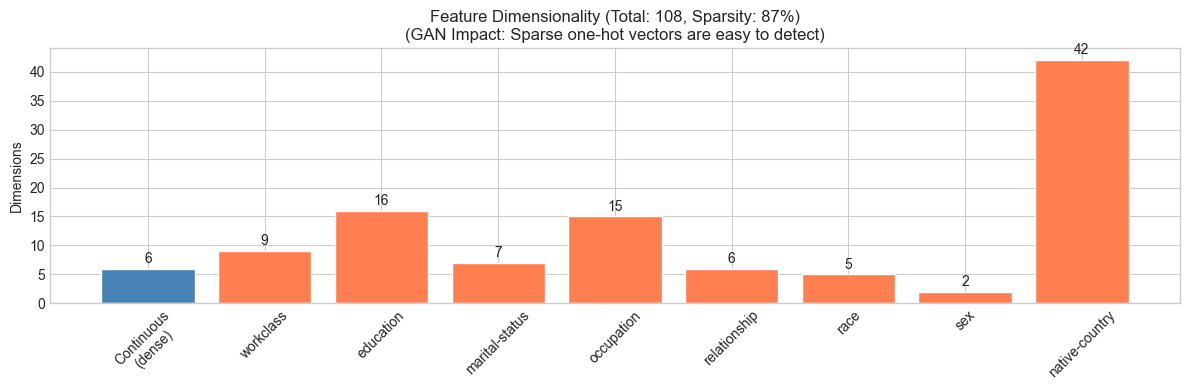

In [19]:
# Visualize one-hot sparsity
fig, ax = plt.subplots(figsize=(12, 4))

categories = ['Continuous\n(dense)'] + categorical_features
dims = [len(continuous_features)] + [df[f].nunique() for f in categorical_features]
colors = ['steelblue'] + ['coral'] * len(categorical_features)

bars = ax.bar(categories, dims, color=colors, edgecolor='white')

for bar, dim in zip(bars, dims):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
            str(dim), ha='center', va='bottom', fontsize=10)

ax.set_ylabel('Dimensions')
ax.set_title(f'Feature Dimensionality (Total: {total_dims}, Sparsity: {sparsity:.0f}%)\n'
             f'(GAN Impact: Sparse one-hot vectors are easy to detect)', fontsize=12)
ax.tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

## 11. Feature Interactions

**GAN Impact**: Complex feature interactions must be captured by the generator. Pairwise relationships show dependencies the GAN needs to learn.

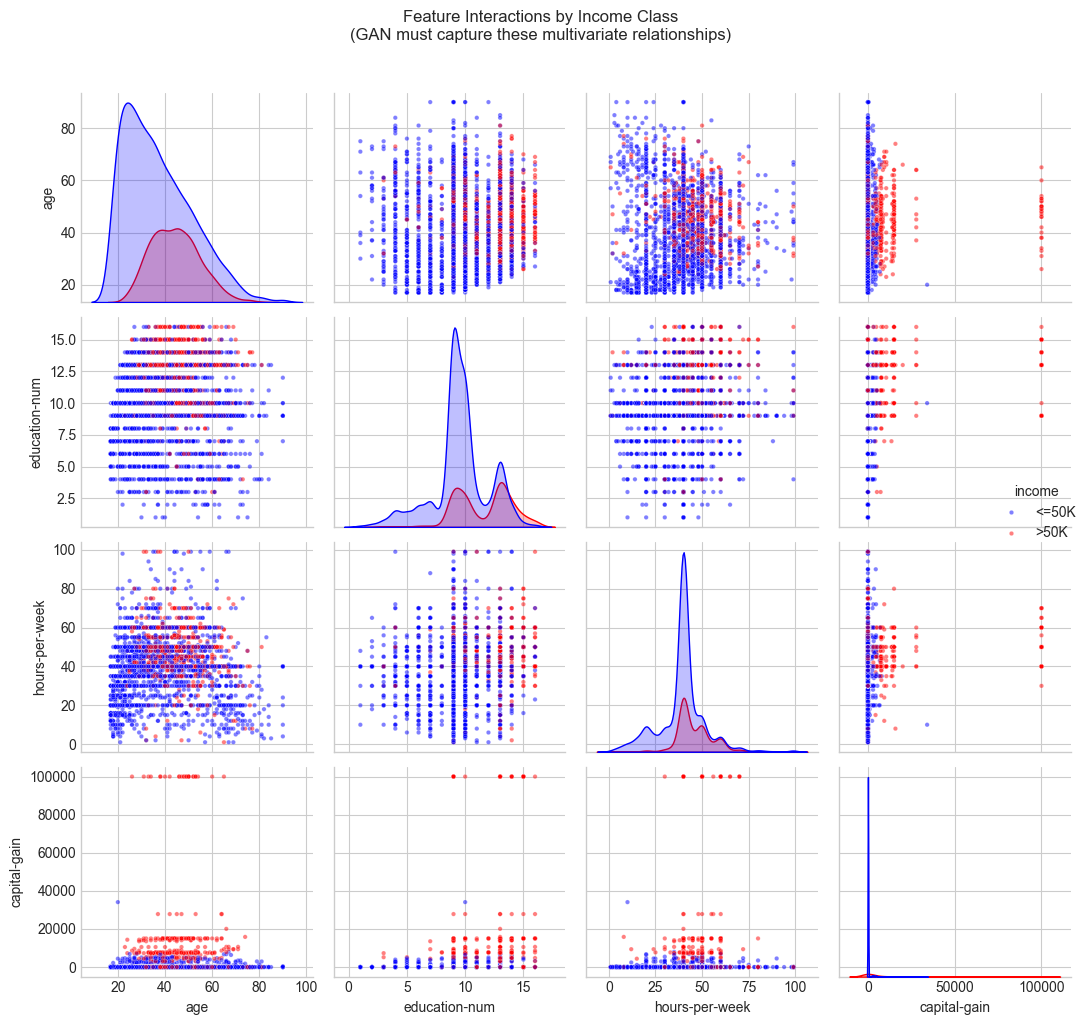

In [20]:
# Pairwise scatter plots for key continuous features
key_features = ['age', 'education-num', 'hours-per-week', 'capital-gain']

# Create a sample for visualization
sample = df.sample(min(5000, len(df)), random_state=42)

# Get unique labels for palette
labels = df[target].unique()
palette = {labels[0]: 'blue', labels[1]: 'red'}

g = sns.pairplot(sample[key_features + [target]], 
                 hue=target, 
                 diag_kind='kde',
                 plot_kws={'alpha': 0.5, 's': 10},
                 palette=palette)

g.fig.suptitle('Feature Interactions by Income Class\n(GAN must capture these multivariate relationships)', 
               y=1.02, fontsize=12)
plt.tight_layout()
plt.show()

In [21]:
# Cross-tabulation for key categorical interactions
print("Key Categorical Interactions:")
print("="*60)

# Education vs Occupation
print("\nEducation vs Occupation (top 5 each):")
top_edu = df['education'].value_counts().head(5).index
top_occ = df['occupation'].value_counts().head(5).index
crosstab = pd.crosstab(df[df['education'].isin(top_edu)]['education'], 
                       df[df['occupation'].isin(top_occ)]['occupation'], 
                       normalize='index') * 100
print(crosstab.round(1))

Key Categorical Interactions:

Education vs Occupation (top 5 each):
occupation    Adm-clerical  Craft-repair  Exec-managerial  Prof-specialty  \
education                                                                   
Assoc-voc             19.8          29.8             17.8            20.1   
Bachelors             11.5           5.1             31.1            33.9   
HS-grad               25.3          35.6             15.0             4.3   
Masters                4.3           1.4             31.9            53.8   
Some-college          28.7          19.4             19.7             9.6   

occupation    Sales  
education            
Assoc-voc      12.5  
Bachelors      18.4  
HS-grad        19.8  
Masters         8.5  
Some-college   22.6  


## 12. Recommendations Summary

Based on the EDA findings, here are specific recommendations for improving GAN/cGAN performance:

In [22]:
print("="*70)
print("           EDA RECOMMENDATIONS FOR GAN/cGAN OPTIMIZATION")
print("="*70)

print("\n[1] MODE-SPECIFIC NORMALIZATION")
print("-" * 50)
multimodal = dist_df[dist_df['n_modes'] > 1]['feature'].tolist()
if multimodal:
    print(f"    Features with multiple modes: {multimodal}")
    print("    Recommendation: Use Gaussian Mixture Model-based normalization")
else:
    print("    No strongly multimodal features detected")

print("\n[2] ZERO-INFLATED FEATURES")
print("-" * 50)
print("    capital-gain: 91-95% zeros")
print("    capital-loss: 91-95% zeros")
print("    Recommendation: Use separate zero-mask prediction + log-transform")
print("    Status: Already implemented in current model")

print("\n[3] CLASS IMBALANCE MITIGATION")
print("-" * 50)
print(f"    Target imbalance ratio: ~3:1 (76% vs 24%)")
print("    Recommendation: Use training-by-sampling (cGAN)")
print("    Status: cGAN implementation addresses this")

print("\n[4] OUTLIER HANDLING")
print("-" * 50)
high_outlier_features = outlier_df[outlier_df['Pct'] > 5]['Feature'].tolist()
if high_outlier_features:
    print(f"    High outlier features: {high_outlier_features}")
    print("    Recommendation: Consider clipping or robust scaling")
else:
    print("    No features with >5% outliers")

print("\n[5] RARE CATEGORY HANDLING")
print("-" * 50)
rare_summary = cat_df[cat_df['Rare (<1%)'] > 0][['Feature', 'Rare (<1%)']]
if len(rare_summary) > 0:
    for _, row in rare_summary.iterrows():
        print(f"    {row['Feature']}: {row['Rare (<1%)']} rare categories")
    print("    Recommendation: Consider grouping rare categories or oversampling")

print("\n[6] CATEGORICAL ENCODING")
print("-" * 50)
print(f"    One-hot dimensionality: {total_onehot_dims} dimensions")
print(f"    Total feature space: {total_dims} dimensions")
print(f"    Sparsity: {sparsity:.1f}%")
print("    Recommendation: Use Gumbel-Softmax for differentiable sampling")
print("    Status: Already implemented in current model")

print("\n[7] KEY CORRELATIONS TO PRESERVE")
print("-" * 50)
print("    Feature-target associations detected (use for cGAN conditioning)")
print("    Strongest predictors: education-num, capital-gain, hours-per-week")

print("\n" + "="*70)
print("                         END OF EDA ANALYSIS")
print("="*70)

           EDA RECOMMENDATIONS FOR GAN/cGAN OPTIMIZATION

[1] MODE-SPECIFIC NORMALIZATION
--------------------------------------------------
    Features with multiple modes: ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
    Recommendation: Use Gaussian Mixture Model-based normalization

[2] ZERO-INFLATED FEATURES
--------------------------------------------------
    capital-gain: 91-95% zeros
    capital-loss: 91-95% zeros
    Recommendation: Use separate zero-mask prediction + log-transform
    Status: Already implemented in current model

[3] CLASS IMBALANCE MITIGATION
--------------------------------------------------
    Target imbalance ratio: ~3:1 (76% vs 24%)
    Recommendation: Use training-by-sampling (cGAN)
    Status: cGAN implementation addresses this

[4] OUTLIER HANDLING
--------------------------------------------------
    High outlier features: ['capital-gain', 'hours-per-week']
    Recommendation: Consider clipping or robust sc